# Análisis Curva-S en el Mercado Doméstico de Brasil

## Información Importante

El siguiente cuaderno permite analizar las curvas-S del mercado doméstico de Brasil, procesando distintos datos de la ANAC. Estos códigos fueron programados por Andrés Ariztía, estudiante de 4to año de Ingeniería en la Pontificia Universidad Católica de Chile, guiado por los profesores Sebastián Raveau y Felipe Delgado, Profesores Asociados del Departamento de Ingeniería en Transportes y Logística de dicha universidad. Gran parte de las celdas fueron pensadas con la ayuda de varios *prompts* de ChatGPT, consultados entre agosto y noviembre del año 2024.

# 1. Leer Base de Datos

En primer lugar, para encontrar la base de datos principal de este análisis, se debe ir a la página web de la ANAC, www.gov.br/anac . Luego, en la barra de menú se debe ir a Assuntos -> Dados e Estatísticas -> Mercado do Transporte Aéreo -> Demanda e Oferta . Luego, en la sección BASE DE DADOS, se debe ir a Microdados -> Dados y Descargar el archivo 'Combinada' del mes que se quiera analizar. En el repositorio se encuentran los datos de Agosto de 2024, los cuales se procederá a leer con el siguiente código:

Por otro lado, se debe decidir si se quiere analizar solo los vuelos **directos**, o si se quiere considerar los vuelos directos y con escalas en conjunto. Para eso es importante activar (o no) la línea de código señalada. En este caso, se decidió considerar la suma de pasajeros directos y con escala:

El código demorará entre 15 y 20 minutos en Correr

In [ ]:
import pandas as pd
import chardet

input_file = 'combinada2024-02.txt' # Reemplazar según mes que se quiera analizar
output_file = 'feb-24.xlsx' # Ídem

with open(input_file, 'rb') as file:
    result = chardet.detect(file.read())
encoding = result['encoding']


df = pd.read_csv(input_file, delimiter=';', encoding=encoding)

# Para analizar solo los vuelos nacionales de las tres aerolíneas principales
df = df[(df['sg_empresa_icao'] == 'TAM') | (df['sg_empresa_icao'] == 'GLO') | (df['sg_empresa_icao'] == 'AZU') & (df['cd_cotran'] == 'N') & (df['cd_tipo_linha'] == 'N')]

# Para analizar solo vuelos directos
# df = df[df['ds_cotran'] == 'DESEMBARQUE']

# Para seleccionar solo las columnas de interés
df = df[['sg_empresa_icao', 'nr_voo', 'dt_referencia', 'nr_semana_referencia', 'nm_dia_semana_referencia', 
         'cd_tipo_linha', 'ds_tipo_linha', 'sg_icao_origem', 'sg_icao_destino', 'nr_escala_destino', 
         'cd_cotran', 'ds_cotran', 'nr_passag_pagos', 'nr_passag_gratis']]


C:\Users\aariz\AppData\Local\Temp\ipykernel_16056\711614360.py:12: DtypeWarning: Columns (8,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_file, delimiter=';', encoding=encoding)


In [2]:
df.to_excel('feb-24.xlsx')

Luego, se debe agrupar según Nº de vuelo, fecha, origen y destino:

In [2]:
df_agrupado = df.groupby(['nr_voo', 'dt_referencia', 'sg_icao_origem', 'sg_icao_destino']).agg({   
    'sg_empresa_icao': 'first',
    'nm_dia_semana_referencia': 'first',  
    'nr_semana_referencia': 'first',
    'nr_passag_pagos': 'sum',
    'nr_passag_gratis': 'sum',
}).reset_index()

A continuación, corresponde completar la segunda parte de la base de datos, la cual permitirá obtener las capacidades de cada vuelo. Para eso, será necesario volver a la página web de la ANAC, pero esta vez, en la sección Assuntos, se deberá ir a Dados e Estatísticas -> Passageiros -> Dados do Mercado de Transporte Aéreo -> Tarifas Aéreas. Ahi, en la secciíon Microdados, se debe ir al link de 'Accesse os microdados' e ir al link 'https://sas.anac.gov.br/sas/downloads/view/frmDownload.aspx' (o similar). En esa página, se debe seleccionar en Tema 'Registro Serviços Aéreos - Voos em frequências - Arquivos diários', el año que se quiera analizar y presionar 'Buscar Arquivos'. En este repositorio se está analizando agosto de 2024, por lo que se procedió a seleccionar y posteriormente descargar los archivos de dicho mes (31 en total), los cuales se encuentran en la carpeta 'diarios agosto' de este mismo repositorio. Para otros meses proceder de la misma manera.

Esos archivos son diarios, por lo que el código que sigue sirve para agruparlo en un puro df mensual, y posteriormente cruzarlo con el archivo anterior:

In [3]:
import os

carpeta = 'diarios agosto' # Cambiar si se quiere revisar otro mes
dataframes = []

for archivo in os.listdir(carpeta):
    ruta_completa = os.path.join(carpeta, archivo)
    if os.path.isfile(ruta_completa):
        fecha = ruta_completa[-14:-4]
        df = pd.read_csv(ruta_completa, delimiter=';', header=0, encoding='utf-8', low_memory=False, skiprows=1)

        df['Situação SIROS'] = df['Situação SIROS'].replace('Em Operação', 1)

        df = df[(df['Cód. Empresa'] == 'TAM') | (df['Cód. Empresa'] == 'GLO') | (df['Cód. Empresa'] == 'AZU')]

        df = df[(df['Situação SIROS'] == 1)]
        
        df.rename(columns={
            'Cód. Empresa': 'sg_empresa_icao',
            'Nº Voo': 'nr_voo',
            'Quant. Assentos': 'assentos'
        }, inplace=True)
        df['dt_referencia'] = fecha

        df = df[['sg_empresa_icao', 'dt_referencia', 'nr_voo', 'assentos', 'Equip.', 'Situação SIROS']]

        dataframes.append(df)

df_concatenado = pd.concat(dataframes, ignore_index=True)

df_concatenado['nr_voo'] = df_concatenado['nr_voo'].astype(str)
df_agrupado['nr_voo'] = df_agrupado['nr_voo'].astype(str)
df_resultado = pd.merge(df_agrupado, df_concatenado[['nr_voo', 'dt_referencia', 'assentos']], 
                        on=['nr_voo', 'dt_referencia'], 
                        how='left')

aux = df_resultado[(df_resultado['nr_passag_pagos'] > 0) & (df_resultado['assentos'] > 0)]
aux['ocupacion'] = aux['nr_passag_pagos'] / aux['assentos']

final = aux[aux['ocupacion'] <= 1] # Elimina vuelos con ocupación mayor a 1 por inconsistencia

output = {
    'total' : int((aux['ocupacion']).count()),
    'incompletos' : int((df_resultado['assentos'] == 0).sum()),
    'inconsistentes' : int(((aux['ocupacion']).count() - (final['ocupacion'] > 0).count())),
    'correctos' : int((final['ocupacion'] > 0).count())
}

final.to_excel(output_file)

print(output)

C:\Users\aariz\AppData\Local\Temp\ipykernel_18196\2341696122.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux['ocupacion'] = aux['nr_passag_pagos'] / aux['assentos']


{'total': 85060, 'incompletos': 2360, 'inconsistentes': 2712, 'correctos': 82348}


Luego, en caso que se quiera concatenar con más meses, como el caso de los meses considerados como 'corporativos' o 'vacaciones'. En este repositorio no se encuentran los archivos de los demás meses, pero estos pueden ser facilmente obtenidos siguiendo los pasos mencionados más arriba. Los archivos mencionados se encuentran en el repositorio, pero de todas formas, se pueden generar utilizando el siguiente código:

In [ ]:
marzo = pd.read_excel('mar-24.xlsx')
abril = pd.read_excel('abr-24.xlsx')
mayo = pd.read_excel('may-24.xlsx')
junio = pd.read_excel('jun-24.xlsx')
agosto = pd.read_excel('ago-24.xlsx')

corporativos = pd.concat([marzo, abril, mayo, junio, agosto], ignore_index=True)

corporativos.to_excel('corporativos.csv')

# Análogamente

enero = pd.read_excel('ene-24.xlsx')
febrero = pd.read_excel('feb-24.xlsx')
julio = pd.read_excel('jul-24.xlsx')

corporativos = pd.concat([enero, febrero, julio], ignore_index=True)

corporativos.to_excel('vacaciones.csv')

Con todo lo anterior ya se tienen las bases de datos listas para ser analizadas.

# 2. Análisis Rutas

Las funciones que vienen permiten hacer un análisis que compara el Marketshare con el Seatshare y el Frechare de cada ruta para cada día. Se entiende como Seatshare, la proporción de asientos que representa la suma de asientos que ofrece una aerolínea, respecto al total ofrecido en es día por las tres aerolíneas. Análogamente el frechare hace lo mismo con las frecuencias

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.optimize import minimize

In [72]:
def repetir_empresas_dia(df):
    grouped = df.groupby('dt_referencia')['sg_empresa_icao'].nunique()
    return list(grouped.items())

def identificar_df(corporativo):
    if corporativo:
        a = pd.read_csv('corporativos.csv')
        df = a[~a['nm_dia_semana_referencia'].isin(['SÁBADO', 'DOMINGO'])]    
    else:
        df = pd.read_csv('vacaciones.csv')
    return df

def share_diario(data, df):
    data = [int(x) for x in data]
    repeated_data = []
    diario_empresas = repetir_empresas_dia(df)
    for i in range(len(data)):
        for j in range(int(diario_empresas[i][1])):
            repeated_data.append(data[i])      
    dataf = pd.DataFrame(repeated_data, columns=['values'])
    return dataf

def agrupar_df(rutas, df, frecshare, aerolineas):
    total_pasajeros = 0
    total_frecuencias = 0
    total_asientos = 0

    for ruta in rutas:
        if ruta[0] == 'SP':
            filtro = df[(((df['sg_icao_origem'] == 'SBSP') | (df['sg_icao_origem'] == 'SBGR')) & (df['sg_icao_destino'] == ruta[1])) | ((df['sg_icao_origem'] == ruta[1]) & ((df['sg_icao_origem'] == 'SBSP') | (df['sg_icao_origem'] == 'SBGR')))]
        else:
            filtro = df[((df['sg_icao_origem'] == ruta[0]) & (df['sg_icao_destino'] == ruta[1])) | ((df['sg_icao_origem'] == ruta[1]) & (df['sg_icao_origem'] == ruta[0]))]
    
        df_agrupado = filtro.groupby(['dt_referencia', 'sg_empresa_icao']).agg(frecuencias=('dt_referencia', 'size'), plazas_ofrecidas=('assentos', 'sum'), pasajeros=('nr_passag_pagos', 'sum')).reset_index()
        prueba = df_agrupado.groupby(['dt_referencia']).agg(total_pasajeros=('pasajeros', 'sum'), total_frecuencias=('frecuencias', 'sum'), total_plazas=('plazas_ofrecidas', 'sum')).reset_index()

        df_agrupado['total_pasajeros'] = share_diario(prueba['total_pasajeros'].to_list(), filtro)
        df_agrupado['total_frecuencias'] = share_diario(prueba['total_frecuencias'].to_list(), filtro)
        df_agrupado['total_plazas'] = share_diario(prueba['total_plazas'].to_list(), filtro)

        df_agrupado['seatshare'] = df_agrupado['plazas_ofrecidas']/df_agrupado['total_plazas']
        df_agrupado['frecshare'] = df_agrupado['frecuencias']/df_agrupado['total_frecuencias']
        df_agrupado['marketshare'] = df_agrupado['pasajeros']/df_agrupado['total_pasajeros']

        if aerolineas:
            colores = {'AZU' : 'blue', 'TAM' : 'red', 'GLO' : '#9beb34'}
        else:
            colores = {'AZU' : 'black', 'TAM' : 'black', 'GLO' : 'black'}
        df_agrupado['color'] = df_agrupado['sg_empresa_icao'].map(colores)

        if frecshare:
            plt.scatter(df_agrupado['frecshare'], df_agrupado['marketshare'], c=df_agrupado['color'], marker='o', s=0.1)
        else: 
            plt.scatter(df_agrupado['seatshare'], df_agrupado['marketshare'], c=df_agrupado['color'], marker='o', s=0.1)

        total_pasajeros += df_agrupado["pasajeros"].sum()
        total_asientos += df_agrupado["plazas_ofrecidas"].sum()
        total_frecuencias += df_agrupado["frecuencias"].sum()

    return df_agrupado, total_frecuencias, total_pasajeros, total_asientos


def generar_grafico(corporativo, rutas, frecshare, aerolineas):
    plt.figure(figsize=(10, 5))

    df = identificar_df(corporativo)
    df_agrupado, total_frecuencias, total_pasajeros, total_asientos = agrupar_df(rutas, df, frecshare, aerolineas)

    # Ajuste curva
    
    def poly3(x, a, b, c):
        return a * x**3 + b * x**2 + c * x

    def residuals(params):
        a, b, c = params
        if frecshare:
            return np.sum((poly3(df_agrupado['frecshare'].values, a, b, c) - df_agrupado['marketshare'].values) ** 2) + (poly3(1, a, b, c) - 1) ** 2
        else:
            return np.sum((poly3(df_agrupado['seatshare'].values, a, b, c) - df_agrupado['marketshare'].values) ** 2) + (poly3(1, a, b, c) - 1) ** 2

    result = minimize(residuals, [0, 0, 0])
    a_opt, b_opt, c_opt = result.x
    x_curve = np.linspace(0, 1, 200)
    y_curve = poly3(x_curve, a_opt, b_opt, c_opt)

    # Gráfico

    plt.plot(x_curve, y_curve, color='blue', lw=0.5, linestyle='--')
    plt.text(0.8, 0.1, f"""Pax: {total_pasajeros} 
{f"Flights: {total_frecuencias}" if frecshare else f"Seats: {total_asientos}"}""", 
             fontsize=12, color='black', bbox=dict(facecolor='white', alpha=0.7))
    plt.plot([0, 1], [0, 1], linestyle='--', linewidth=0.5, color='red') 

    if aerolineas:
        plt.scatter([], [], color='#9beb34', label='Gol')
        plt.scatter([], [], color='red', label='Latam')
        plt.scatter([], [], color='blue', label='Azul')
        plt.legend()

    # plt.title(f'Estudio {"Frec" if frecshare else "Seat"}share vs Marketshare')
    plt.xlabel(f'{"Frequency" if frecshare else "Seats"} share')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.ylabel('Passenger Share')
    plt.grid(False)
    plt.show()
    
    return

Posteriormente, se procede a definir los segmentos. Para definir los segmentos turísticos, se comparó la cantidad de vuelos en enero de 2024 respecto a abril de 2024. Así, los pares origen-destino que tengan mayor aumento en enero dentro de los 75 más populares, se considerarían como pares OD turísticos. El siguiento código permite hacer ese análisis:

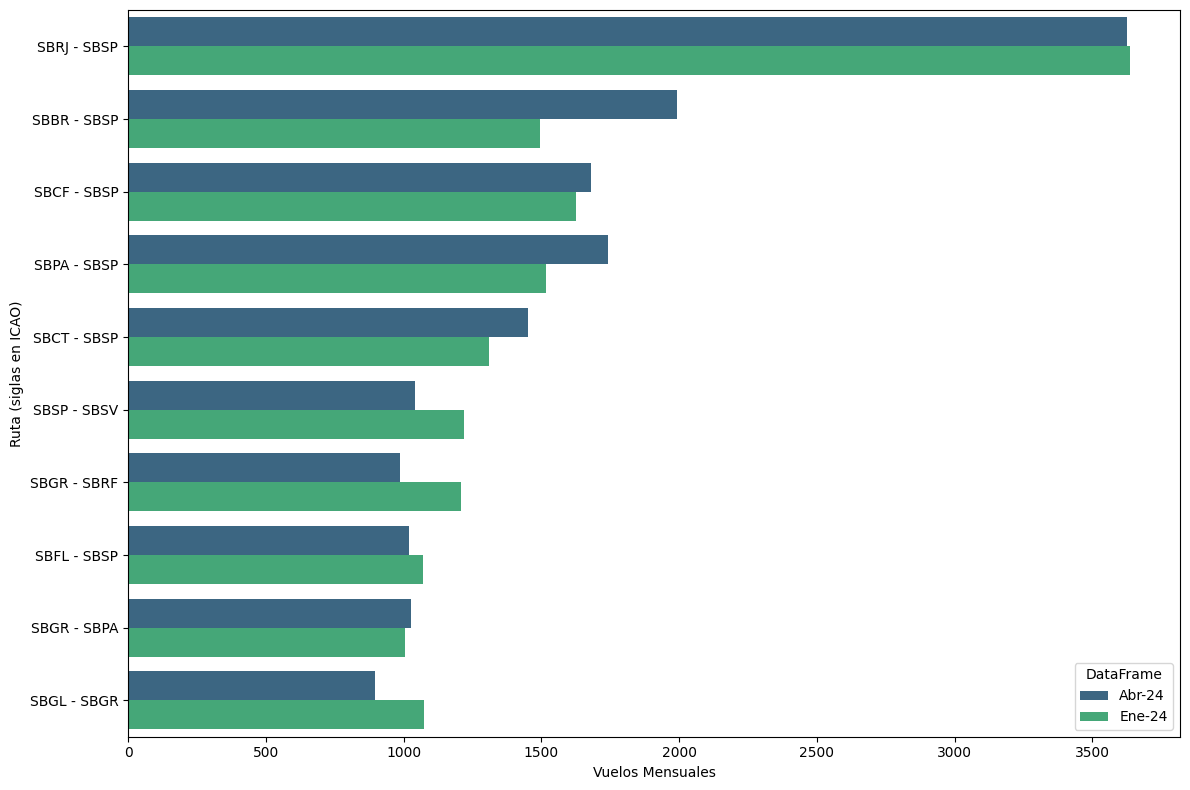

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

abr = pd.read_excel('abr-24.xlsx')
ene = pd.read_excel('ene-24.xlsx')

def normalizar_rutas(df):
    df['ruta_normalizada'] = df.apply(lambda x: tuple(sorted([x['sg_icao_origem'], x['sg_icao_destino']])), axis=1)
    return df

df1_normalizado = normalizar_rutas(abr)
df2_normalizado = normalizar_rutas(ene)
rutas_df1 = df1_normalizado.groupby('ruta_normalizada').size().reset_index(name='repeticiones_df1')
rutas_df2 = df2_normalizado.groupby('ruta_normalizada').size().reset_index(name='repeticiones_df2')

evolucion_rutas = pd.merge(rutas_df1, rutas_df2, on='ruta_normalizada', how='outer')

evolucion_rutas.fillna(0, inplace=True)

evolucion_rutas['total_repeticiones'] = evolucion_rutas['repeticiones_df1'] + evolucion_rutas['repeticiones_df2']
top_75_rutas = evolucion_rutas.sort_values(by='total_repeticiones', ascending=False).iloc[:75]

top_75_rutas['ruta'] = top_75_rutas['ruta_normalizada'].apply(lambda x: ' - '.join(x))
df_largo = top_75_rutas.melt(id_vars='ruta', value_vars=['repeticiones_df1', 'repeticiones_df2'],
                             var_name='DataFrame', value_name='Repeticiones')


df_largo['DataFrame'] = df_largo['DataFrame'].replace({'repeticiones_df1': 'Abr-24', 'repeticiones_df2': 'Ene-24'})


plt.figure(figsize=(12, 25))
sns.barplot(x='Repeticiones', y='ruta', hue='DataFrame', data=df_largo, palette='viridis')
plt.xlabel('Vuelos Mensuales')
plt.ylabel('Ruta (siglas en ICAO)')
# plt.title('Top 25 Rutas con Más Repeticiones en DF1 y DF2')
plt.tight_layout()
plt.show()

Con esa información fue posible construir los segmentos turísticos. Los segmentos corporativos fueron construidos por investigación independiente. Se escriben las rutas según sus siglas ICAO porque así están en la base de datos (es importante que se haga así, sino el código no corre):

In [5]:
segmentos = {
    'hub-hub' : [['SBSP', 'SBRJ']],
    '16-40 2 inc' : [['SBSP', 'SBSV'], ['SBSP', 'SBFL'], ['SP', 'SBFZ']],
    '16-40 3 inc' : [['SP', 'SBRF'], ['SBSP', 'SBBR'], ['SBSP', 'SBCT'], ['SBSP', 'SBCF']],
    '5-15 2 inc' : [['SBKP', 'SBBR'], ['SBKP', 'SBGL'], ['SBSP', 'SBVT'], ['SBGR', 'SBGL'], ['SBBR', 'SBRJ'], ['SBBR', 'SBGR'], ['SBGL', 'SBVT'], ['SBSP', 'SBGO']],
    '5-15 3 inc' : [['SBGR', 'SBEG'], ['SBBR', 'SBCF'], ['SBGL', 'SBCF'], ['SBGR', 'SBCT'], ['SBCY', 'SBGR'], ['SBGR', 'SBRF']],
    '10+ leis 2 inc' : [['SBSP', 'SBFL'], ['SBGL', 'SBGR'], ['SBBR', 'SBGR'], ['SBSP', 'SBNF']],
    '10+ leis 3 inc' : [['SBSP', 'SBSV'], ['SBGL', 'SBSV'], ['SBSP', 'SBRF'], ['SBGR', 'SBRF']],
    '5-10 leis 2 inc': [['SBSV', 'SBRF'], ['SBGR', 'SBSG'], ['SBGR', 'SBMO'], ['SBFL', 'SBGR'], ['SBFZ', 'SBRF'], ['SBGR', 'SBAR'], ['SBCF', 'SBSV'], ['SBFN', 'SBRF']],
    '5-10 leis 3 inc': [['SBBE', 'SBMQ'], ['SBFL', 'SBGL'], ['SBGL', 'SBFZ'], ['SBBR', 'SBSV'], ['SP', 'SBPS']]
}

Ya está todo listo para obtener los gráficos, en la fución que se presenta a continuación, se debe indicar:

- Si se quiere analizar un segemnto corporativo o no
- Las rutas del diccionario de segmentos anterior
- Si se quiere revisar el frecshare o el seatshare
- Por último, si se quiere hacer distinción entre aerolíneas.

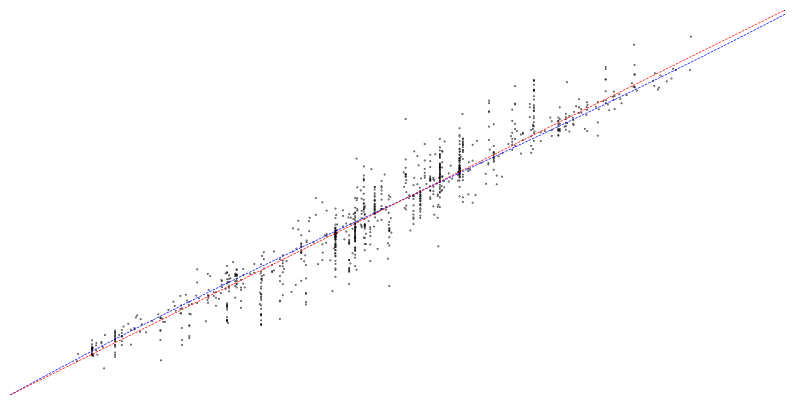

In [71]:
generar_grafico(corporativo=True, # False si el segmento es turístico
                 rutas=segmentos['5-10 leis 3 inc'], # Indicar segmento a analizar
                   frecshare=False, # False si se quiere revisar Seatshare
                     aerolineas=False) # False para no hacer distinciones entre aerolíneas